<a href="https://colab.research.google.com/github/meetptl04/ImageStyleTranfer/blob/main/ImageStryleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

## Image Processing Class
* The `ImageProcessing` class provides static methods for loading and processing images for neural network input, and for converting processed images back to a viewable format. Specifically, it resizes and normalizes images for VGG19 and performs de-normalization for display.

In [ ]:
# Image Processing Class
class ImageProcessing:
    @staticmethod
    def load_and_process_img(path_to_img):
        max_dim = 512
        img = tf.keras.preprocessing.image.load_img(path_to_img)
        img = tf.keras.preprocessing.image.img_to_array(img)

        long = max(img.shape[:-1])
        scale = max_dim / long
        img = tf.image.resize(img, (round(img.shape[0] * scale), round(img.shape[1] * scale)))
        img = tf.keras.applications.vgg19.preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        return img

    @staticmethod
    def deprocess_img(processed_img):
        x = processed_img.copy()
        if len(x.shape) == 4:
            x = np.squeeze(x, 0)
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x

## Loss Function Class
* This class defines a model that calculates the style and content loss for image style transfer.

In [ ]:
# Loss Functions Class
class LossFunctions:
    @staticmethod
    def get_content_loss(base_content, target):
        return tf.reduce_mean(tf.square(base_content - target))

    @staticmethod
    def gram_matrix(input_tensor):
        channels = int(input_tensor.shape[-1])
        a = tf.reshape(input_tensor, [-1, channels])
        n = tf.shape(a)[0]
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(n, tf.float32)

    @staticmethod
    def get_style_loss(base_style, gram_target):
        height, width, channels = base_style.get_shape().as_list()
        gram_style = LossFunctions.gram_matrix(base_style)
        return tf.reduce_mean(tf.square(gram_style - gram_target))

## VGG Model Class
* The `VGGModel` class initializes a VGG19 model pre-trained on ImageNet, extracts feature representations for content and style images, and provides methods to obtain these features for style transfer tasks.

In [ ]:
# VGG Model Class
class VGGModel:
    def __init__(self):
        self.model = self._get_model()

    def _get_model(self):
        vgg = VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        content_layers = ['block5_conv2']
        style_layers = ['block1_conv1', 'block2_conv1',
                        'block3_conv1', 'block4_conv1',
                        'block5_conv1']

        content_output = [vgg.get_layer(layer).output for layer in content_layers]
        style_outputs = [vgg.get_layer(layer).output for layer in style_layers]

        model_outputs = style_outputs + content_output

        return Model(vgg.input, model_outputs)

    def get_feature_representations(self, content_path, style_path):
        content_image = ImageProcessing.load_and_process_img(content_path)
        style_image = ImageProcessing.load_and_process_img(style_path)

        # Extract feature representations
        content_features = self.model(content_image)[-1]
        style_features = self.model(style_image)[:-1]

        return style_features, content_features

## Style Transfer Class
* The `StyleTransfer` class handles the process of applying style transfer to an image using a VGG19 model. It computes losses for style and content features, calculates gradients to update the image, and iteratively optimizes the image to match the style of one image and the content of another. It provides methods to compute losses and gradients, and to perform style transfer over a specified number of iterations, returning the final stylized image and its associated loss.

In [ ]:
# Style Transfer Class
class StyleTransfer:
    def __init__(self, vgg_model, style_weight=1e-2, content_weight=1e3):
        self.vgg_model = vgg_model
        self.style_weight = style_weight
        self.content_weight = content_weight

    def compute_loss(self, init_image, gram_style_features, content_features):
        model_outputs = self.vgg_model.model(init_image)

        style_output_features = model_outputs[:len(gram_style_features)]
        content_output_features = model_outputs[len(gram_style_features):]

        style_score = 0
        content_score = 0

        weight_per_style_layer = 1.0 / float(len(gram_style_features))
        for target_style, comb_style in zip(gram_style_features, style_output_features):
            style_score += weight_per_style_layer * LossFunctions.get_style_loss(comb_style[0], target_style)

        weight_per_content_layer = 1.0 / float(len(content_features))
        for target_content, comb_content in zip(content_features, content_output_features):
            content_score += weight_per_content_layer * LossFunctions.get_content_loss(comb_content[0], target_content)

        style_score *= self.style_weight
        content_score *= self.content_weight

        loss = style_score + content_score
        return loss, style_score, content_score

    def compute_grads(self, init_image, gram_style_features, content_features):
        with tf.GradientTape() as tape:
            all_loss = self.compute_loss(init_image, gram_style_features, content_features)
        total_loss = all_loss[0]
        return tape.gradient(total_loss, init_image), all_loss

    def run_style_transfer(self, content_path, style_path, num_iterations=1000):
        style_features, content_features = self.vgg_model.get_feature_representations(content_path, style_path)
        gram_style_features = [LossFunctions.gram_matrix(style_feature) for style_feature in style_features]

        init_image = ImageProcessing.load_and_process_img(content_path)
        init_image = tf.Variable(init_image, dtype=tf.float32)

        opt = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)

        iter_count = 1
        best_loss, best_img = float('inf'), None

        norm_means = np.array([103.939, 116.779, 123.68])
        min_vals = -norm_means
        max_vals = 255 - norm_means

        for i in range(num_iterations):
            grads, all_loss = self.compute_grads(init_image, gram_style_features, content_features)
            loss, style_score, content_score = all_loss
            opt.apply_gradients([(grads, init_image)])
            clipped = tf.clip_by_value(init_image, min_vals, max_vals)
            init_image.assign(clipped)

            if loss < best_loss:
                best_loss = loss
                best_img = ImageProcessing.deprocess_img(init_image.numpy())

            if i % 100 == 0:
                print(f'Iteration: {i}, Total loss: {loss}, Style loss: {style_score}, Content loss: {content_score}')

        return best_img, best_loss

## Visualization Class
* The `Visualization` class provides static methods to display images, including showing final results and images from file paths, using Matplotlib for visualization.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Visualization:
    @staticmethod
    def show_results(best_img):
        plt.figure(figsize=(10, 10))
        plt.imshow(best_img)
        plt.title('Final Image')
        plt.axis('off')  # Hide axes
        plt.show()

    @staticmethod
    def show_image_matplotlib(image_path):
        try:
            img = mpimg.imread(image_path)
            plt.figure(figsize=(10, 10))
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.show()
        except Exception as e:
            print(f"An error occurred: {e}")

# Initialize the classes
vgg_model = VGGModel()
style_transfer = StyleTransfer(vgg_model)
visualizer = Visualization()

original_image = '/content/the-starry-night.jpg'  # Replace with your image path
style_image = '/content/Fantasy-Garden.png'

# Run the style transfer
best_img, best_loss = style_transfer.run_style_transfer(original_image, style_image)

# # Display images
# visualizer.show_image_matplotlib(original_image)
# visualizer.show_image_matplotlib(style_image)

# # Display the resulting image
# visualizer.show_results(best_img)


Iteration: 0, Total loss: 1129928576.0, Style loss: 1129928576.0, Content loss: 0.0
Iteration: 100, Total loss: 19065452.0, Style loss: 14895828.0, Content loss: 4169623.5
Iteration: 200, Total loss: 9250156.0, Style loss: 5620820.5, Content loss: 3629336.0
Iteration: 300, Total loss: 5583365.5, Style loss: 2701050.5, Content loss: 2882315.0
Iteration: 400, Total loss: 3940367.0, Style loss: 1621306.5, Content loss: 2319060.5
Iteration: 500, Total loss: 3083060.5, Style loss: 1141870.875, Content loss: 1941189.5
Iteration: 600, Total loss: 2576207.75, Style loss: 895219.5625, Content loss: 1680988.25
Iteration: 700, Total loss: 2256615.0, Style loss: 755947.3125, Content loss: 1500667.75
Iteration: 800, Total loss: 2042372.875, Style loss: 666394.25, Content loss: 1375978.625
Iteration: 900, Total loss: 1885598.25, Style loss: 606692.6875, Content loss: 1278905.625


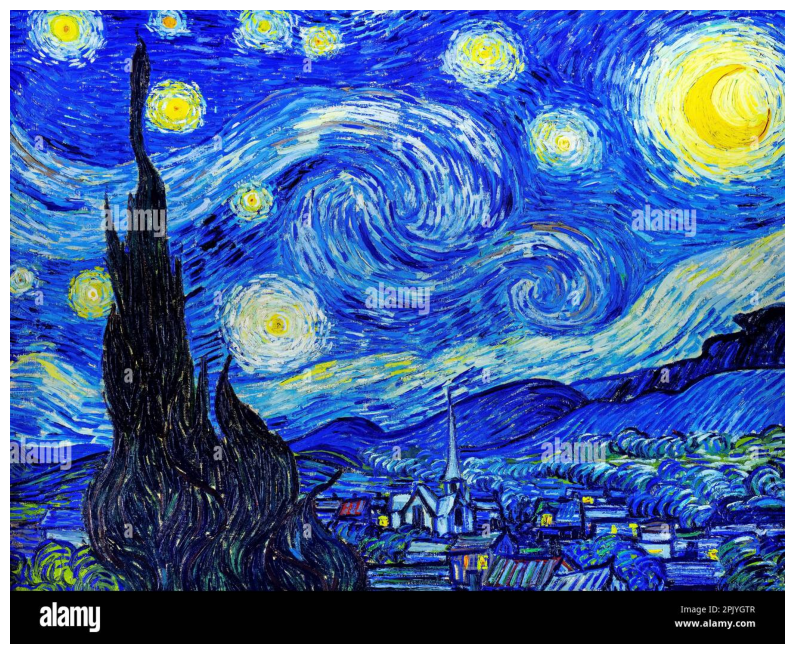

In [12]:
# Display images
visualizer.show_image_matplotlib(original_image)

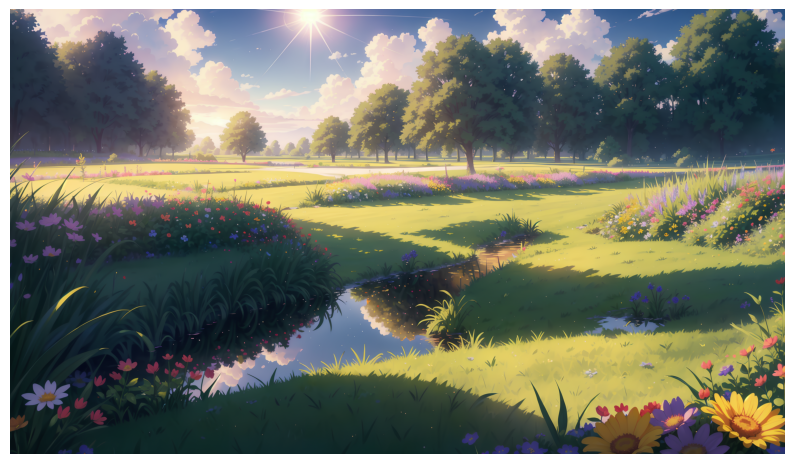

In [13]:
visualizer.show_image_matplotlib(style_image)

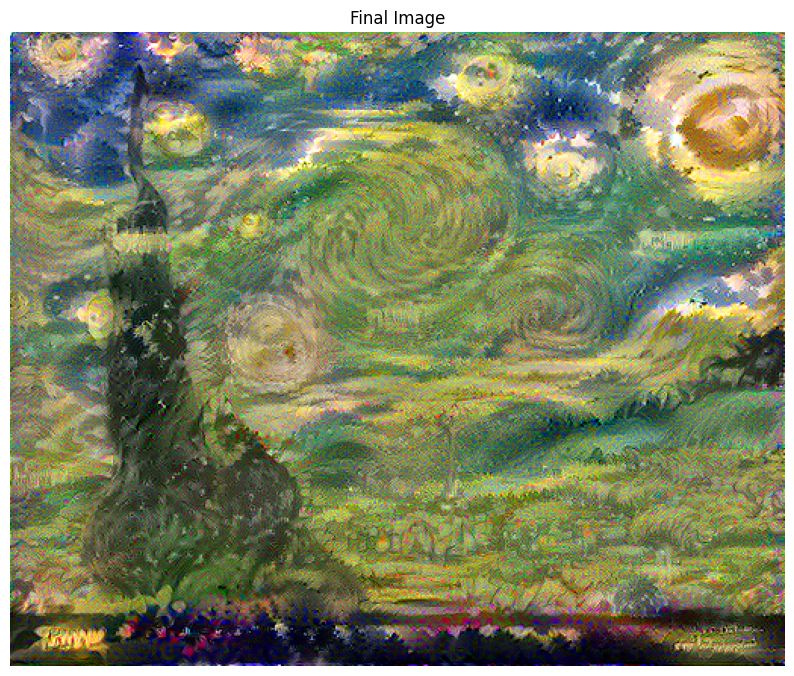

In [14]:
# Display the resulting image
visualizer.show_results(best_img)